In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
!pip install timm
import timm
import pandas as pd 
import random
import math

In [2]:
class DenseNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.timm_model = timm.create_model('densenet201', pretrained=True, in_chans=1)
        self.fc = nn.Linear(1000, 30)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.timm_model(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

In [3]:
class EfficientNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.timm_model = timm.create_model('tf_efficientnetv2_s', pretrained=True, in_chans=1)
        self.fc = nn.Linear(1000, 30)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.timm_model(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

In [4]:
class MobileNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.timm_model = timm.create_model('mobilenetv3_large_100', pretrained=True, in_chans=1)
        self.fc = nn.Linear(1000, 30)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.timm_model(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

In [5]:
class InceptionNextModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.timm_model = timm.create_model('inception_next_small', pretrained=True, in_chans=1)
        self.fc = nn.Linear(1000, 30)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.timm_model(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

In [6]:
class MyDataset(data.Dataset):
    def __init__(self, mode, images, targets=None):
        super().__init__()
        self.mode = mode
        self.images = images
        self.targets = targets
    
    def transform(self, image, target=None):
        image = transforms.ToTensor()(image)
        if self.mode == 'train':
            p = random.random()
            if p > 0.5:
                image = transforms.GaussianBlur(5)(image)
                           
            p = random.random()
            if p > 0.5:
                mask = torch.rand(size=image.shape)
                mask[mask > 0.95] = 0
                mask[mask <= 0.95] = 1
                image = mask * image
            '''
            p = random.random()
            if p > 0.5: 
                image = transforms.functional.hflip(image)
                idx = target == -1
                target[::2] = 96 - target[::2]
                target[idx] = -1
            '''
            p = random.random()
            if p > 0.5:  
                angle = random.randint(-20, 20)
                image = transforms.functional.rotate(image, angle=angle)
                angle = -angle
                idx = target == -1
                angle_radians = math.radians(angle)
                x = (target[::2] - 48) * math.cos(angle_radians) - (target[1::2] - 48) * math.sin(angle_radians)
                y = (target[::2] - 48) * math.sin(angle_radians) + (target[1::2] - 48) * math.cos(angle_radians)
                target[::2] = x + 48
                target[1::2] = y + 48
                target[idx] = -1

        if self.mode == 'train' or self.mode == 'val':
            return image, target
        else:
            return image
        
    def __getitem__(self, index):
        if self.mode == 'train' or self.mode == 'val':
            return self.transform(self.images[index], target=self.targets[index])
        else:
            return self.transform(self.images[index])

    def __len__(self):
        return self.images.shape[0]

In [7]:
def reshape_images(images):
    images_reshaped = np.zeros((images.shape[0], 96, 96, 1))
    for i, img in enumerate(images):
        img = img.split(' ')
        img = np.array([int(num) for num in img])
        img = img.reshape((96, 96, 1))
        images_reshaped[i] = img
    
    return images_reshaped
        
raw = pd.read_csv('/kaggle/input/facial-keypoints-detection/training.zip', compression='zip')
raw = raw.sample(frac=1)
features_name = list(raw)   
features_name.remove('Image')
images = raw['Image']
targets = raw.drop(columns=['Image'])
targets = targets.fillna(-1).to_numpy()

train_images = images[0: int(raw.shape[0] * 0.999)]
train_targets = targets[0: int(raw.shape[0] * 0.999)]
train_images = reshape_images(train_images)
    
val_images = images[int(raw.shape[0] * 0.999): ]
val_targets = targets[int(raw.shape[0] * 0.999): ]
val_images = reshape_images(val_images)

raw = pd.read_csv('/kaggle/input/facial-keypoints-detection/test.zip', compression='zip')
test_images = raw['Image']
test_images = reshape_images(test_images)

In [8]:
loss_func = nn.MSELoss()
batch_size = 64
learning_rate = 0.001
num_epochs = 210
decay_every = 30
decay = 0.25

In [9]:
train_dataset = MyDataset('train', train_images, train_targets)
val_dataset = MyDataset('val', val_images, val_targets)
test_dataset = MyDataset('test', test_images)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
models = [InceptionNextModel(), MobileNetModel(), DenseNetModel(), EfficientNetModel()]

model.safetensors:   0%|          | 0.00/198M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

epoch: 1
train - loss: 3.097
val - loss: 1.919
epoch: 2
train - loss: 2.387
val - loss: 1.911
epoch: 3
train - loss: 4.298
val - loss: 3.518
epoch: 4
train - loss: 2.232
val - loss: 1.541
epoch: 5
train - loss: 2.276
val - loss: 1.823
epoch: 6
train - loss: 2.115
val - loss: 1.724
epoch: 7
train - loss: 1.584
val - loss: 1.296
epoch: 8
train - loss: 1.876
val - loss: 1.397
epoch: 9
train - loss: 2.114
val - loss: 1.537
epoch: 10
train - loss: 1.467
val - loss: 1.029
epoch: 11
train - loss: 1.932
val - loss: 1.889
epoch: 12
train - loss: 2.886
val - loss: 3.034
epoch: 13
train - loss: 1.394
val - loss: 1.1
epoch: 14
train - loss: 1.371
val - loss: 1.27
epoch: 15
train - loss: 1.403
val - loss: 1.133
epoch: 16
train - loss: 1.381
val - loss: 1.212
epoch: 17
train - loss: 1.202
val - loss: 1.044
epoch: 18
train - loss: 1.832
val - loss: 1.677
epoch: 19
train - loss: 1.17
val - loss: 1.005
epoch: 20
train - loss: 1.205
val - loss: 1.019
epoch: 21
train - loss: 2.026
val - loss: 1.796
epoch

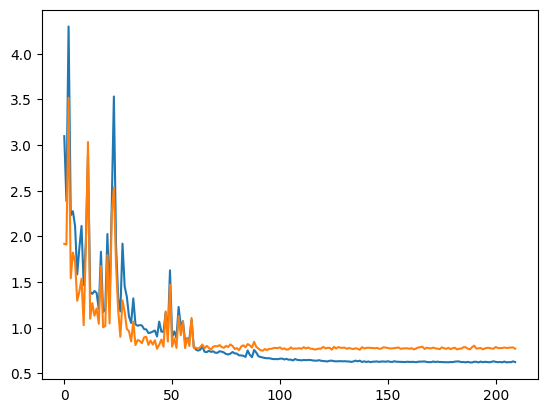

epoch: 1
train - loss: 2.928
val - loss: 2.092
epoch: 2
train - loss: 2.434
val - loss: 1.685
epoch: 3
train - loss: 2.335
val - loss: 1.829
epoch: 4
train - loss: 2.319
val - loss: 2.086
epoch: 5
train - loss: 2.011
val - loss: 1.717
epoch: 6
train - loss: 2.761
val - loss: 2.576
epoch: 7
train - loss: 1.928
val - loss: 1.572
epoch: 8
train - loss: 3.274
val - loss: 3.231
epoch: 9
train - loss: 2.014
val - loss: 1.801
epoch: 10
train - loss: 1.609
val - loss: 1.349
epoch: 11
train - loss: 2.896
val - loss: 2.551
epoch: 12
train - loss: 2.71
val - loss: 2.242
epoch: 13
train - loss: 1.524
val - loss: 1.337
epoch: 14
train - loss: 1.424
val - loss: 1.149
epoch: 15
train - loss: 1.912
val - loss: 1.769
epoch: 16
train - loss: 2.882
val - loss: 2.517
epoch: 17
train - loss: 1.398
val - loss: 1.385
epoch: 18
train - loss: 1.296
val - loss: 1.015
epoch: 19
train - loss: 1.32
val - loss: 1.213
epoch: 20
train - loss: 1.36
val - loss: 1.081
epoch: 21
train - loss: 1.708
val - loss: 1.568
epoc

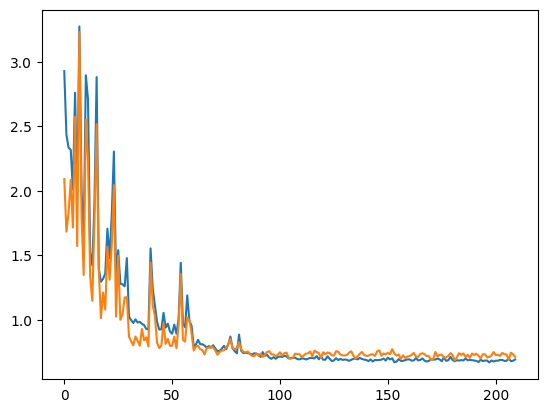

epoch: 1
train - loss: 2.897
val - loss: 2.32
epoch: 2
train - loss: 2.507
val - loss: 1.783
epoch: 3
train - loss: 1.891
val - loss: 1.334
epoch: 4
train - loss: 1.74
val - loss: 1.479
epoch: 5
train - loss: 2.589
val - loss: 2.23
epoch: 6
train - loss: 1.935
val - loss: 1.646
epoch: 7
train - loss: 1.862
val - loss: 1.763
epoch: 8
train - loss: 1.44
val - loss: 1.083
epoch: 9
train - loss: 1.554
val - loss: 1.241
epoch: 10
train - loss: 2.932
val - loss: 2.656
epoch: 11
train - loss: 1.812
val - loss: 1.567
epoch: 12
train - loss: 1.208
val - loss: 0.9904
epoch: 13
train - loss: 1.622
val - loss: 1.405
epoch: 14
train - loss: 1.933
val - loss: 1.744
epoch: 15
train - loss: 1.733
val - loss: 1.538
epoch: 16
train - loss: 1.25
val - loss: 1.112
epoch: 17
train - loss: 1.229
val - loss: 0.9875
epoch: 18
train - loss: 1.227
val - loss: 1.021
epoch: 19
train - loss: 1.499
val - loss: 1.241
epoch: 20
train - loss: 1.445
val - loss: 1.194
epoch: 21
train - loss: 2.538
val - loss: 2.453
epoc

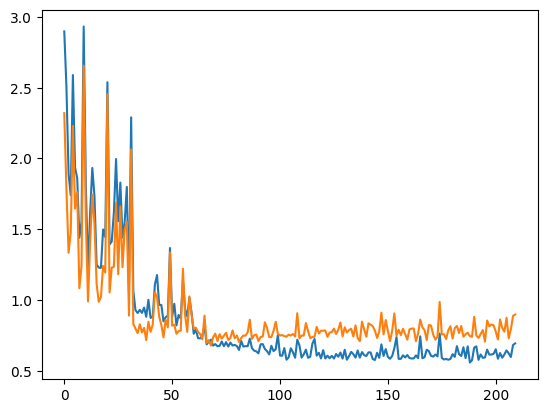

epoch: 1
train - loss: 3.306
val - loss: 2.534
epoch: 2
train - loss: 3.018
val - loss: 2.774
epoch: 3
train - loss: 2.137
val - loss: 1.678
epoch: 4
train - loss: 1.886
val - loss: 1.564
epoch: 5
train - loss: 3.109
val - loss: 2.78
epoch: 6
train - loss: 1.902
val - loss: 1.475
epoch: 7
train - loss: 3.893
val - loss: 3.675
epoch: 8
train - loss: 1.973
val - loss: 1.68
epoch: 9
train - loss: 1.497
val - loss: 1.14
epoch: 10
train - loss: 2.912
val - loss: 2.558
epoch: 11
train - loss: 1.379
val - loss: 1.067
epoch: 12
train - loss: 1.849
val - loss: 1.712
epoch: 13
train - loss: 1.718
val - loss: 1.468
epoch: 14
train - loss: 2.791
val - loss: 2.633
epoch: 15
train - loss: 1.69
val - loss: 1.607
epoch: 16
train - loss: 1.828
val - loss: 1.67
epoch: 17
train - loss: 3.468
val - loss: 3.44
epoch: 18
train - loss: 1.441
val - loss: 1.455
epoch: 19
train - loss: 1.764
val - loss: 1.742
epoch: 20
train - loss: 1.306
val - loss: 1.113
epoch: 21
train - loss: 1.317
val - loss: 1.016
epoch: 

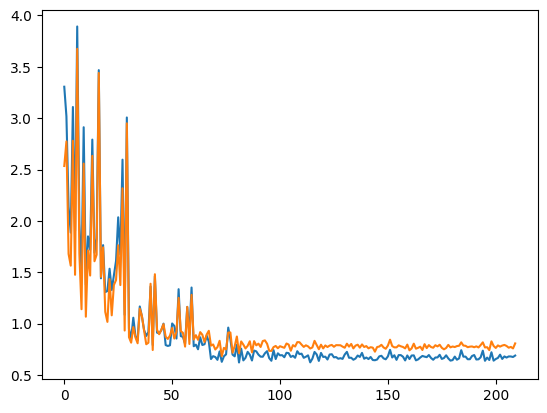

In [11]:
for model in models:
    all_epochs_train_loss = []
    all_epochs_val_loss = []
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)
    scheduler = StepLR(optimizer, decay_every, gamma=decay)
    for epoch in range(1, num_epochs + 1):
        print('epoch:', epoch)
        model.train()
        for samples, targets in train_loader:
            '''
            plt.imshow(samples[0].permute(1, 2, 0).numpy(), cmap='gray')
            plt.scatter(targets[0][::2], targets[0][1::2], color='red', marker='o', s=3)
            plt.show()       
            '''
            samples = samples.to(device).float()
            targets = targets.to(device).float()
            preds = model(samples)
            idx = targets == -1
            preds[idx] = -1
            loss = loss_func(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

        scheduler.step()
        model.eval() 
        with torch.no_grad():
            for mode, loader in zip(['train', 'val'], [train_loader, val_loader]):
                epoch_loss, num_samples = 0, 0
                for samples, targets in loader:
                    samples = samples.to(device).float()
                    targets = targets.to(device).float()
                    preds = model(samples)
                    idx = targets == -1
                    preds[idx] = -1
                    loss = loss_func(preds, targets)
                    epoch_loss += loss.item() * targets.shape[0] 
                    num_samples += targets.shape[0]

                epoch_loss = np.sqrt(epoch_loss / num_samples)
                if mode == 'train':
                    all_epochs_train_loss.append(epoch_loss)
                else:
                    all_epochs_val_loss.append(epoch_loss)
                print(mode, '- loss:', f'{epoch_loss:.4}')
            
    plt.plot(np.arange(num_epochs), all_epochs_train_loss, np.arange(num_epochs), all_epochs_val_loss)
    plt.show()

In [12]:
# Save the models
model_paths = ["inception_next.pth", "mobile_net.pth", "dense_net.pth", "efficient_net.pth"]

for model, path in zip(models, model_paths):
    torch.save(model.state_dict(), path)

In [13]:
all_locs = []
for model in models:
    loc = []
    model.eval() 
    with torch.no_grad():
        for samples in test_loader:
            samples = samples.to(device).float()
            preds = model(samples)
            loc = loc + preds.flatten().tolist()
    
    all_locs.append(loc)

loc = np.array(all_locs).mean(axis=0)

In [14]:
df = pd.DataFrame({'ImageId': np.array([[i] * 30 for i in range(1, 1784)]).flatten(),
                   'FeatureName': features_name * 1783,
                   'Location': loc})
sample_sub = pd.read_csv('/kaggle/input/facial-keypoints-detection/IdLookupTable.csv')
preds = df.merge(sample_sub, on=['ImageId', 'FeatureName'])['Location_x']
sub = pd.read_csv('/kaggle/input/facial-keypoints-detection/SampleSubmission.csv')
sub['Location'] = preds
sub.to_csv('submission.csv',index = False)